In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

sidr_data = genfromtxt('sveidr_vacc2_sim2.csv', delimiter=',') #in the form of [t,S,V1,V2,E,I,D,R]

torch.manual_seed(1234)

In [2]:
sidr_data.shape

(15, 100)

In [3]:
%%time

PATH = 'svidr_norm_simple' 

class DINN(nn.Module):
    def __init__(self, t, S1_data, V11_data, V12_data, E1_data, I1_data, D1_data, R1_data, 
                 S2_data, V21_data, V22_data, E2_data, I2_data, D2_data, R2_data): #[t,S,V1,V2,E,I,D,R]
        super(DINN, self).__init__()
        self.N = 3.5e7 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S1 = torch.tensor(S1_data)
        self.V11 = torch.tensor(V11_data)
        self.V12 = torch.tensor(V12_data)
        self.E1 = torch.tensor(E1_data)
        self.I1 = torch.tensor(I1_data)
        self.D1 = torch.tensor(D1_data)
        self.R1 = torch.tensor(R1_data)
        self.S2 = torch.tensor(S2_data)
        self.V21 = torch.tensor(V21_data)
        self.V22 = torch.tensor(V22_data)
        self.E2 = torch.tensor(E2_data)
        self.I2 = torch.tensor(I2_data)
        self.D2 = torch.tensor(D2_data)
        self.R2 = torch.tensor(R2_data)

        self.losses = []
        self.save = 2 #which file to save to

        self.alpha1_tilda = torch.nn.Parameter(torch.rand(1,requires_grad=True))
        self.alpha2_tilda = torch.nn.Parameter(torch.rand(1,requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.sigma1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.sigma2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.lbda_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.rho_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.M00_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.M01_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.M11_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        
        #find values for normalization
        self.S1_max, self.S2_max = max(self.S1), max(self.S2)
        self.V11_max, self.V21_max = max(self.V11), max(self.V21)
        self.V12_max, self.V22_max = max(self.V12), max(self.V22)
        self.E1_max, self.E2_max = max(self.E1), max(self.E2)
        self.I1_max, self.I2_max = max(self.I1), max(self.I2)
        self.D1_max, self.D2_max = max(self.D1), max(self.D2)
        self.R1_max, self.R2_max = max(self.R1), max(self.R2)
        self.S1_min, self.S2_min = min(self.S1), min(self.S2)
        self.V11_min, self.V21_min = min(self.V11), min(self.V21)
        self.V12_min, self.V22_min = min(self.V12), min(self.V22)
        self.E1_min, self.E2_min = min(self.E1), min(self.E2)
        self.I1_min, self.I2_min = min(self.I1), min(self.I2)
        self.D1_min, self.D2_min = min(self.D1), min(self.D2)
        self.R1_min, self.R2_min = min(self.R1), min(self.R2)

        #normalize
        self.S1_hat = (self.S1 - self.S1_min) / (self.S1_max - self.S1_min)
        self.V11_hat = (self.V11 - self.V11_min) / (self.V11_max - self.V11_min)
        self.V12_hat = (self.V12 - self.V12_min) / (self.V12_max - self.V12_min)
        self.E1_hat = (self.E1 - self.E1_min) / (self.E1_max - self.E1_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.D1_hat = (self.D1 - self.D1_min) / (self.D1_max - self.D1_min)
        self.R1_hat = (self.R1 - self.R1_min) / (self.R1_max - self.R1_min)

        self.S2_hat = (self.S2 - self.S2_min) / (self.S2_max - self.S2_min)
        self.V21_hat = (self.V21 - self.V21_min) / (self.V21_max - self.V21_min)
        self.V22_hat = (self.V22 - self.V22_min) / (self.V22_max - self.V22_min)
        self.E2_hat = (self.E2 - self.E2_min) / (self.E2_max - self.E2_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.D2_hat = (self.D2 - self.D2_min) / (self.D2_max - self.D2_min)
        self.R2_hat = (self.R2 - self.R2_min) / (self.R2_max - self.R2_min)

        #matrices (x14 for S,V_1,V_2,E,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 14)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 14)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 14)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 14)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 14)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 14)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 14)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 14)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 14)); self.m9[:, 8] = 1
        self.m10 = torch.zeros((len(self.t), 14)); self.m10[:, 9] = 1
        self.m11 = torch.zeros((len(self.t), 14)); self.m11[:, 10] = 1
        self.m12 = torch.zeros((len(self.t), 14)); self.m12[:, 11] = 1
        self.m13 = torch.zeros((len(self.t), 14)); self.m13[:, 12] = 1
        self.m14 = torch.zeros((len(self.t), 14)); self.m14[:, 13] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha1_tilda, self.alpha2_tilda, self.beta_tilda, self.gamma_tilda, 
                                 self.sigma1_tilda, self.sigma2_tilda, 
                                 self.lbda_tilda, self.rho_tilda, 
                                 self.M00_tilda, self.M01_tilda, self.M11_tilda]))


    @property
    def alpha1(self):
        return torch.tanh(self.alpha1_tilda) * 3.5e-3
    
    @property
    def alpha2(self):
        return torch.tanh(self.alpha2_tilda) * 5e-3

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) *0.05 + 0.3 #[0.25, 0.35]
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) *0.02 + 0.18 #[0.16, 0.2]
    
    @property
    def sigma1(self):
        return torch.tanh(self.sigma1_tilda) *0.02 + 0.05 #[0.03, 0.07]

    @property
    def sigma2(self):
        return torch.tanh(self.sigma2_tilda) *0.02 + 0.15  #[0.13, 0.17]

    @property
    def lbda(self):
        return torch.tanh(self.lbda_tilda) *0.02 + 0.06 #[0.04, 0.08]
    
    @property
    def rho(self):
        return torch.tanh(self.rho_tilda)*0.05 + 0.1 #[0.05, 0.15] 

    @property
    def M00(self):
        return torch.tanh(self.M00_tilda)*0.1 + 20.7  #[20.6,20.8]

    @property
    def M01(self):
        return torch.tanh(self.M01_tilda)*0.1 + 6.3  
    
    @property
    def M11(self):
        return torch.tanh(self.M11_tilda)*0.1 + 10.4  #[10.3,10.5]
    

    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 14) #outputs S, V_1,V_2, E, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S1_hat, V11_hat, V12_hat, E1_hat, I1_hat, D1_hat, R1_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3], sidr_hat[:,4], sidr_hat[:,5], sidr_hat[:,6]
        S2_hat, V21_hat, V22_hat, E2_hat, I2_hat, D2_hat, R2_hat = sidr_hat[:,7], sidr_hat[:,8], sidr_hat[:,9], sidr_hat[:,10], sidr_hat[:,11], sidr_hat[:,12], sidr_hat[:,13]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        S1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m8, retain_graph=True)
        S2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V_1_t
        sidr_hat.backward(self.m2, retain_graph=True)
        V11_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m9, retain_graph=True)
        V21_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V_2_t
        sidr_hat.backward(self.m3, retain_graph=True)
        V12_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m10, retain_graph=True)
        V22_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #E_t
        sidr_hat.backward(self.m4, retain_graph=True)
        E1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m11, retain_graph=True)
        E2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m5, retain_graph=True)
        I1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m12, retain_graph=True)
        I2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m6, retain_graph=True)
        D1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m13, retain_graph=True)
        D2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m7, retain_graph=True)
        R1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        sidr_hat.backward(self.m14, retain_graph=True)
        R2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S1 = self.S1_min + (self.S1_max - self.S1_min) * S1_hat
        V11 = self.V11_min + (self.V11_max - self.V11_min) * V11_hat
        V12 = self.V12_min + (self.V12_max - self.V12_min) * V12_hat
        E1 = self.E1_min + (self.E1_max - self.E1_min) * E1_hat
        I1 = self.I1_min + (self.I1_max - self.I1_min) * I1_hat
        D1 = self.D1_min + (self.D1_max - self.D1_min) * D1_hat      
        R1 = self.R1_min + (self.R1_max - self.R1_min) * R1_hat

        S2 = self.S2_min + (self.S2_max - self.S2_min) * S2_hat
        V21 = self.V21_min + (self.V21_max - self.V21_min) * V21_hat
        V22 = self.V22_min + (self.V22_max - self.V22_min) * V22_hat
        E2 = self.E2_min + (self.E2_max - self.E2_min) * E2_hat
        I2 = self.I2_min + (self.I2_max - self.I2_min) * I2_hat
        D2 = self.D2_min + (self.D2_max - self.D2_min) * D2_hat      
        R2 = self.R2_min + (self.R2_max - self.R2_min) * R2_hat

        f1_hat = S1_hat_t - (-self.beta/self.N * S1 * (self.M00*I1+self.M01*I2) - (self.alpha1+self.alpha2)*S1) / (self.S1_max - self.S1_min)
        f2_hat = V11_hat_t - (self.alpha1*S1 - self.sigma1*self.beta/self.N*V11 * (self.M00*I1+self.M01*I2)) / (self.V11_max - self.V11_min)
        f3_hat = V12_hat_t - (self.alpha2*S1 - self.sigma2*self.beta/self.N*V12 * (self.M00*I1+self.M01*I2)) / (self.V12_max - self.V12_min)
        f4_hat = E1_hat_t - (self.beta/self.N * S1 * (self.M00*I1+self.M01*I2) + (self.sigma1*self.beta/self.N*V11 + self.sigma2*self.beta/self.N*V12) * (self.M00*I1+self.M01*I2) - self.gamma * E1) / (self.E1_max - self.E1_min)
        f5_hat = I1_hat_t - (self.gamma * E1 - self.lbda * I1 - self.rho * I1 ) / (self.I1_max - self.I1_min)
        f6_hat = D1_hat_t - (self.lbda * I1) / (self.D1_max - self.D1_min)
        f7_hat = R1_hat_t - (self.rho * I1 ) / (self.R1_max - self.R1_min)
        
        f8_hat = S2_hat_t - (-self.beta/self.N * S2 * (self.M01*I1+self.M11*I2) - (self.alpha1+self.alpha2)*S2) / (self.S2_max - self.S2_min)
        f9_hat = V21_hat_t - (self.alpha1*S2 - self.sigma1*self.beta/self.N*V21*(self.M01*I1+self.M11*I2)) / (self.V21_max - self.V21_min)
        f10_hat = V22_hat_t - (self.alpha2*S2 - self.sigma2*self.beta/self.N*V22*(self.M01*I1+self.M11*I2)) / (self.V22_max - self.V22_min)
        f11_hat = E2_hat_t - (self.beta/self.N * S2 * (self.M01*I1+self.M11*I2) + (self.sigma1*self.beta/self.N*V21 + self.sigma2*self.beta/self.N*V22) * (self.M01*I1+self.M11*I2) - self.gamma * E2) / (self.E2_max - self.E2_min)
        f12_hat = I2_hat_t - (self.gamma * E2 - self.lbda * I2 - self.rho * I2 ) / (self.I2_max - self.I2_min)
        f13_hat = D2_hat_t - (self.lbda * I2) / (self.D2_max - self.D2_min)
        f14_hat = R2_hat_t - (self.rho * I2 ) / (self.R2_max - self.R2_min)

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, f10_hat, f11_hat, f12_hat, f13_hat, f14_hat, S1_hat, V11_hat, V12_hat, E1_hat, I1_hat, D1_hat, R1_hat, S2_hat, V21_hat, V22_hat, E2_hat, I2_hat, D2_hat, R2_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        self.losses = checkpoint['losses']

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S1_pred_list, V11_pred_list, V12_pred_list, E1_pred_list, I1_pred_list, D1_pred_list, R1_pred_list = [], [], [], [], [], [], []
        S2_pred_list, V21_pred_list, V22_pred_list, E2_pred_list, I2_pred_list, D2_pred_list, R2_pred_list = [], [], [], [], [], [], []
        
        f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, S1_pred, V11_pred, V12_pred, E1_pred, I1_pred, D1_pred, R1_pred, S2_pred, V21_pred, V22_pred, E2_pred, I2_pred, D2_pred, R2_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S1_pred_list.append(self.S1_min + (self.S1_max - self.S1_min) * S1_pred)
        V11_pred_list.append(self.V11_min + (self.V11_max - self.V11_min) * V11_pred) 
        V12_pred_list.append(self.V12_min + (self.V12_max - self.V12_min) * V12_pred) 
        E1_pred_list.append(self.E1_min + (self.E1_max - self.E1_min) * E1_pred) 
        I1_pred_list.append(self.I1_min + (self.I1_max - self.I1_min) * I1_pred)
        D1_pred_list.append(self.D1_min + (self.D1_max - self.D1_min) * D1_pred)
        R1_pred_list.append(self.R1_min + (self.R1_max - self.R1_min) * R1_pred)

        S2_pred_list.append(self.S2_min + (self.S2_max - self.S2_min) * S2_pred)
        V21_pred_list.append(self.V21_min + (self.V21_max - self.V21_min) * V21_pred) 
        V22_pred_list.append(self.V22_min + (self.V22_max - self.V22_min) * V22_pred) 
        E2_pred_list.append(self.E2_min + (self.E2_max - self.E2_min) * E2_pred) 
        I2_pred_list.append(self.I2_min + (self.I2_max - self.I2_min) * I2_pred)
        D2_pred_list.append(self.D2_min + (self.D2_max - self.D2_min) * D2_pred)
        R2_pred_list.append(self.R2_min + (self.R2_max - self.R2_min) * R2_pred)

        train_day = 90

        loss = (torch.mean(torch.square(self.S1_hat[:train_day] - S1_pred[:train_day]))+ 
                torch.mean(torch.square(self.V11_hat[:train_day] - V11_pred[:train_day]))+
                torch.mean(torch.square(self.V12_hat[:train_day] - V12_pred[:train_day]))+
                torch.mean(torch.square(self.E1_hat[:train_day] - E1_pred[:train_day]))+
                torch.mean(torch.square(self.I1_hat[:train_day] - I1_pred[:train_day]))+
                torch.mean(torch.square(self.D1_hat[:train_day] - D1_pred[:train_day]))+
                torch.mean(torch.square(self.R1_hat[:train_day] - R1_pred[:train_day]))+
                torch.mean(torch.square(self.S2_hat[:train_day] - S2_pred[:train_day]))+ 
                torch.mean(torch.square(self.V21_hat[:train_day] - V21_pred[:train_day]))+
                torch.mean(torch.square(self.V22_hat[:train_day] - V22_pred[:train_day]))+
                torch.mean(torch.square(self.E2_hat[:train_day] - E2_pred[:train_day]))+
                torch.mean(torch.square(self.I2_hat[:train_day] - I2_pred[:train_day]))+
                torch.mean(torch.square(self.D2_hat[:train_day] - D2_pred[:train_day]))+
                torch.mean(torch.square(self.R2_hat[:train_day] - R2_pred[:train_day]))+
                torch.mean(torch.square(f1[:train_day]))+
                torch.mean(torch.square(f2[:train_day]))+
                torch.mean(torch.square(f3[:train_day]))+
                torch.mean(torch.square(f4[:train_day]))+
                torch.mean(torch.square(f5[:train_day]))+
                torch.mean(torch.square(f6[:train_day]))+
                torch.mean(torch.square(f7[:train_day]))+
                torch.mean(torch.square(f8[:train_day]))+
                torch.mean(torch.square(f9[:train_day]))+
                torch.mean(torch.square(f10[:train_day]))+
                torch.mean(torch.square(f11[:train_day]))+
                torch.mean(torch.square(f12[:train_day]))+
                torch.mean(torch.square(f13[:train_day]))+
                torch.mean(torch.square(f14[:train_day]))
                ) 

        #loss.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step(loss) 
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)
          print('alpha1: (goal 3.5e-4 ', self.alpha1)
          print('alpha2: (goal 5e-4 ', self.alpha2)
          print('beta: (goal 0.3 ', self.beta)
          print('gamma: (goal 0.18 ', self.gamma)
          print('sigma1: (goal 0.05 ', self.sigma1)
          print('sigma2: (goal 0.15 ', self.sigma2)
          print('lbda: (goal 0.06 ', self.lbda)
          print('rho: (goal 0.1 ', self.rho)
          print('M00: (goal 20.7 ', self.M00)
          print('M01: (goal 6.3 ', self.M01)
          print('M11: (goal 10.4 ', self.M11)
          print('#################################') 

      return S1_pred_list, V11_pred_list, V12_pred_list, E1_pred_list, I1_pred_list, D1_pred_list, R1_pred_list, S2_pred_list, V21_pred_list, V22_pred_list, E2_pred_list, I2_pred_list, D2_pred_list, R2_pred_list

Wall time: 0 ns


In [4]:
%%time

dinn = DINN(sidr_data[0], sidr_data[1], sidr_data[2], sidr_data[3], sidr_data[4], sidr_data[5], 
            sidr_data[6], sidr_data[7], sidr_data[8], sidr_data[9], sidr_data[10], sidr_data[11], sidr_data[12], sidr_data[13], sidr_data[14]) #in the form of [t,S,V,E,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

# scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, mode='min', factor=0.1, patience=1000, min_lr=1e-6, eps=1e-8, threshold=1e-10, threshold_mode='rel', verbose=True)

dinn.scheduler = scheduler

nepochs = int(1e6)

S1_pred_list, V11_pred_list, V12_pred_list, E1_pred_list, I1_pred_list, D1_pred_list, R1_pred_list, S2_pred_list, V21_pred_list, V22_pred_list, E2_pred_list, I2_pred_list, D2_pred_list, R2_pred_list = dinn.train(nepochs) #train


starting training...


Epoch  0
alpha1: (goal 3.5e-4  tensor([0.0001], grad_fn=<MulBackward0>)
alpha2: (goal 5e-4  tensor([0.0019], grad_fn=<MulBackward0>)
beta: (goal 0.3  tensor([0.3127], grad_fn=<AddBackward0>)
gamma: (goal 0.18  tensor([0.1870], grad_fn=<AddBackward0>)
sigma1: (goal 0.05  tensor([0.0512], grad_fn=<AddBackward0>)
sigma2: (goal 0.15  tensor([0.1621], grad_fn=<AddBackward0>)
lbda: (goal 0.06  tensor([0.0610], grad_fn=<AddBackward0>)
rho: (goal 0.1  tensor([0.1218], grad_fn=<AddBackward0>)
M00: (goal 20.7  tensor([20.7587], grad_fn=<AddBackward0>)
M01: (goal 6.3  tensor([6.3320], grad_fn=<AddBackward0>)
M11: (goal 10.4  tensor([10.4655], grad_fn=<AddBackward0>)
#################################

Epoch  1000
alpha1: (goal 3.5e-4  tensor([6.7973e-05], grad_fn=<MulBackward0>)
alpha2: (goal 5e-4  tensor([0.0019], grad_fn=<MulBackward0>)
beta: (goal 0.3  tensor([0.3121], grad_fn=<AddBackward0>)
gamma: (goal 0.18  tensor([0.1868], grad_fn=<AddBackward0>)
sigma1: (goal 0.05 

total loss:  0.0002793997166100125


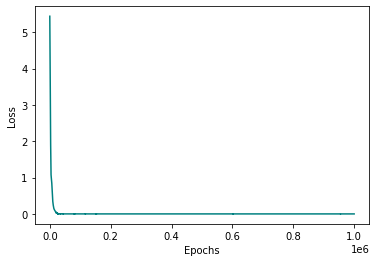

In [5]:
plt.plot(dinn.losses, color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')
print('total loss: ', dinn.losses[-1])

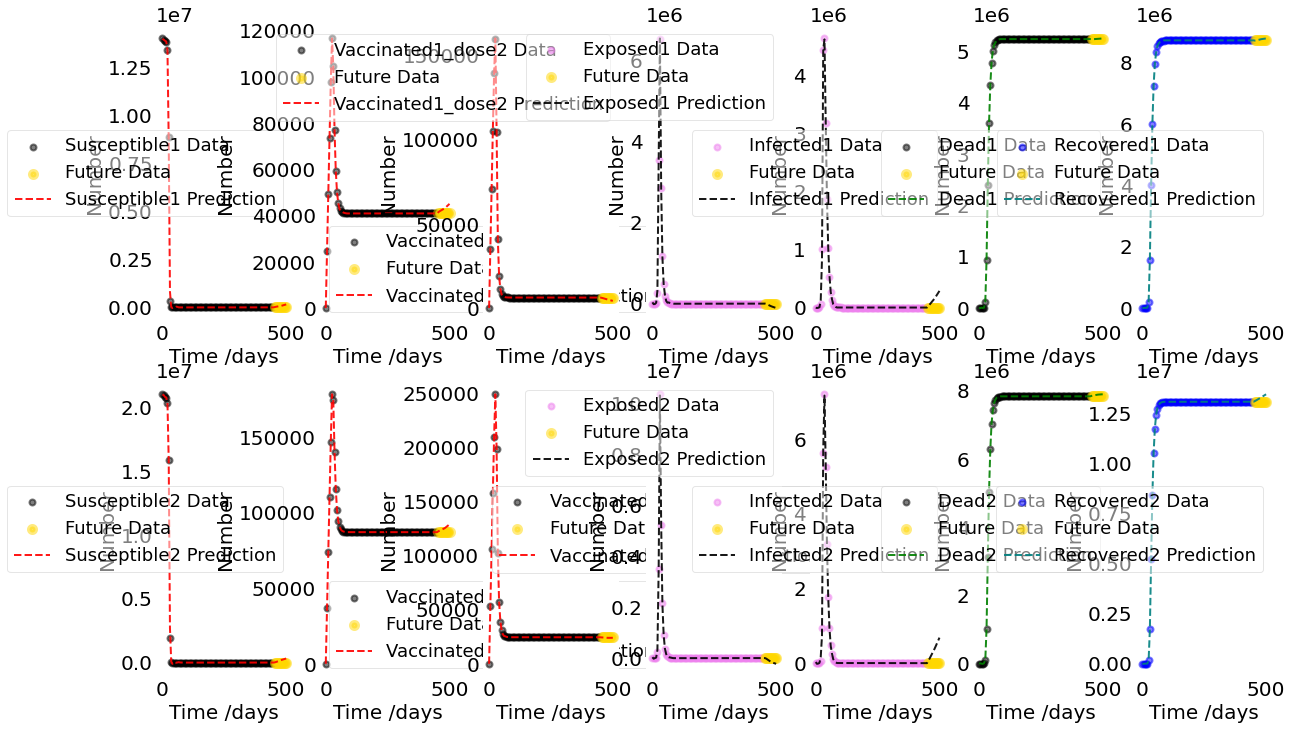

In [6]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(2, 7, figsize = (20,12))

for i in range(2):
    for j in range(5):
        ax[i, j].set_facecolor('xkcd:white')


train_day = 90

ax[0, 0].scatter(sidr_data[0][:train_day], sidr_data[1][:train_day], c = 'black', alpha=0.5, lw=2, label='Susceptible1 Data')
ax[0, 0].scatter(sidr_data[0][train_day:], sidr_data[1][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 0].plot(sidr_data[0], S1_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible1 Prediction', linestyle='dashed')

ax[0, 1].scatter(sidr_data[0][:train_day], sidr_data[2][:train_day], c = 'black', alpha=0.5, lw=2, label='Vaccinated1_dose1 Data')
ax[0, 1].scatter(sidr_data[0][train_day:], sidr_data[2][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 1].plot(sidr_data[0], V11_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated1_dose1 Prediction', linestyle='dashed')

ax[0, 2].scatter(sidr_data[0][:train_day], sidr_data[3][:train_day], c = 'black', alpha=0.5, lw=2, label='Vaccinated1_dose2 Data')
ax[0, 2].scatter(sidr_data[0][train_day:], sidr_data[3][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 2].plot(sidr_data[0], V12_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated1_dose2 Prediction', linestyle='dashed')

ax[0, 3].scatter(sidr_data[0][:train_day], sidr_data[4][:train_day], c = 'violet', alpha=0.5, lw=2, label='Exposed1 Data')
ax[0, 3].scatter(sidr_data[0][train_day:], sidr_data[4][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 3].plot(sidr_data[0], E1_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Exposed1 Prediction', linestyle='dashed')

ax[0, 4].scatter(sidr_data[0][:train_day], sidr_data[5][:train_day], c = 'violet', alpha=0.5, lw=2, label='Infected1 Data')
ax[0, 4].scatter(sidr_data[0][train_day:], sidr_data[5][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 4].plot(sidr_data[0], I1_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Infected1 Prediction', linestyle='dashed')

ax[0, 5].scatter(sidr_data[0][:train_day], sidr_data[6][:train_day], c = 'black', alpha=0.5, lw=2, label='Dead1 Data')
ax[0, 5].scatter(sidr_data[0][train_day:], sidr_data[6][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 5].plot(sidr_data[0], D1_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead1 Prediction', linestyle='dashed')

ax[0, 6].scatter(sidr_data[0][:train_day], sidr_data[7][:train_day], c = 'blue', alpha=0.5, lw=2, label='Recovered1 Data')
ax[0, 6].scatter(sidr_data[0][train_day:], sidr_data[7][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 6].plot(sidr_data[0], R1_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered1 Prediction', linestyle='dashed')

ax[1, 0].scatter(sidr_data[0][:train_day], sidr_data[8][:train_day], c = 'black', alpha=0.5, lw=2, label='Susceptible2 Data')
ax[1, 0].scatter(sidr_data[0][train_day:], sidr_data[8][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 0].plot(sidr_data[0], S2_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible2 Prediction', linestyle='dashed')

ax[1, 1].scatter(sidr_data[0][:train_day], sidr_data[9][:train_day], c = 'black', alpha=0.5, lw=2, label='Vaccinated2_dose1 Data')
ax[1, 1].scatter(sidr_data[0][train_day:], sidr_data[9][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 1].plot(sidr_data[0], V21_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated2_dose1 Prediction', linestyle='dashed')

ax[1, 2].scatter(sidr_data[0][:train_day], sidr_data[10][:train_day], c = 'black', alpha=0.5, lw=2, label='Vaccinated2_dose2 Data')
ax[1, 2].scatter(sidr_data[0][train_day:], sidr_data[10][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 2].plot(sidr_data[0], V22_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated2_dose2 Prediction', linestyle='dashed')

ax[1, 3].scatter(sidr_data[0][:train_day], sidr_data[11][:train_day], c = 'violet', alpha=0.5, lw=2, label='Exposed2 Data')
ax[1, 3].scatter(sidr_data[0][train_day:], sidr_data[11][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 3].plot(sidr_data[0], E2_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Exposed2 Prediction', linestyle='dashed')

ax[1, 4].scatter(sidr_data[0][:train_day], sidr_data[12][:train_day], c = 'violet', alpha=0.5, lw=2, label='Infected2 Data')
ax[1, 4].scatter(sidr_data[0][train_day:], sidr_data[12][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 4].plot(sidr_data[0], I2_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Infected2 Prediction', linestyle='dashed')

ax[1, 5].scatter(sidr_data[0][:train_day], sidr_data[13][:train_day], c = 'black', alpha=0.5, lw=2, label='Dead2 Data')
ax[1, 5].scatter(sidr_data[0][train_day:], sidr_data[13][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 5].plot(sidr_data[0], D2_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead2 Prediction', linestyle='dashed')

ax[1, 6].scatter(sidr_data[0][:train_day], sidr_data[14][:train_day], c = 'blue', alpha=0.5, lw=2, label='Recovered2 Data')
ax[1, 6].scatter(sidr_data[0][train_day:], sidr_data[14][train_day:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 6].plot(sidr_data[0], R2_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered2 Prediction', linestyle='dashed')

for i in range(2):
    for j in range(7):
        ax[i, j].set_xlabel('Time /days',size = 20)
        ax[i, j].set_ylabel('Number',size = 20)
        ax[i, j].yaxis.set_tick_params(length=0)
        ax[i, j].xaxis.set_tick_params(length=0)
        legend = ax[i, j].legend(prop={'size':18})
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax[i, j].spines[spine].set_visible(False)
plt.savefig('vacc_output4_1.png')
plt.show()

alpha1: (goal 3.5e-4  0.0003033344110008329
alpha2: (goal 5e-4  0.0003925814526155591
beta: (goal 0.3  0.31345686316490173
gamma: (goal 0.18  0.18449243903160095
sigma1: (goal 0.05  0.04297838360071182
sigma2: (goal 0.15  0.16858774423599243
lbda: (goal 0.06  0.05248349532485008
rho: (goal 0.1  0.11367444694042206
M00: (goal 20.7  20.649917602539062
M01: (goal 6.3  6.3643999099731445
M11: (goal 10.4  10.48841667175293
#################################


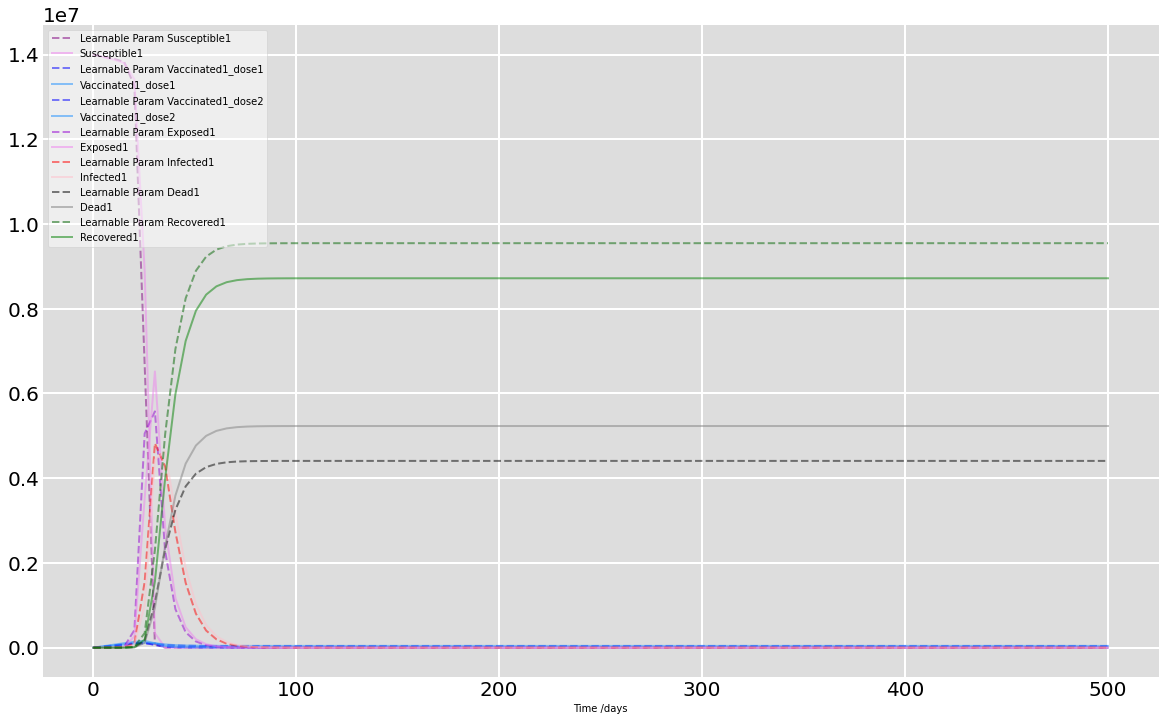

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
N = 3.5e7

init0 = np.array([[N*0.4, N*0.6], #S
          [0, 0], #V1
          [0, 0], #V2
          [0, 0], #E
          [1, 1],
          [0, 0],
          [0, 0]])
# A grid of time points (in days)
t = np.linspace(0, 500, 100) 

#parameters
alpha1 = dinn.alpha1.detach().numpy().item()
alpha2 = dinn.alpha2.detach().numpy().item()
beta = dinn.beta.detach().numpy().item()
gamma = dinn.gamma.detach().numpy().item()
sigma1 = dinn.sigma1.detach().numpy().item()
sigma2 = dinn.sigma2.detach().numpy().item()
lbda = dinn.lbda.detach().numpy().item()
rho = dinn.rho.detach().numpy().item()
M00 = dinn.M00.detach().numpy().item()
M01 = dinn.M01.detach().numpy().item()
M11 = dinn.M11.detach().numpy().item()
print('alpha1: (goal 3.5e-4 ', alpha1)
print('alpha2: (goal 5e-4 ', alpha2)
print('beta: (goal 0.3 ', beta)
print('gamma: (goal 0.18 ', gamma)
print('sigma1: (goal 0.05 ', sigma1)
print('sigma2: (goal 0.15 ', sigma2)
print('lbda: (goal 0.06 ', lbda)
print('rho: (goal 0.1 ', rho)
print('M00: (goal 20.7 ', M00)
print('M01: (goal 6.3 ', M01)
print('M11: (goal 10.4 ', M11)
print('#################################') 
M = np.array([[M00, M01],
              [M01, M11]])

# The SVIDR model differential equations.
def deriv(y, t, age_num, alpha1, alpha2, beta, gamma, sigma1, sigma2, lbda, rho, M):
    S, V1, V2, E, I, D, R = y[0:2], y[2:4], y[4:6], y[6:8], y[8:10], y[10:12], y[12:14]
    dSdt, dV1dt, dV2dt, dEdt, dIdt, dDdt, dRdt = [], [], [], [], [], [], []

    for i in range(age_num): # age for i
        dSdt.append( - beta/N * S[i] * M[i, :].dot(I) - (alpha1+alpha2) * S[i] )
        dV1dt.append( alpha1 * S[i] - sigma1 * beta/N * V1[i] * M[i, :].dot(I) )  # dose 1
        dV2dt.append( alpha2 * S[i] - sigma2 * beta/N * V2[i] * M[i, :].dot(I) )  # dose 2
        dEdt.append( beta/N * S[i] * M[i, :].dot(I) + (sigma1*beta/N*V1[i] + sigma2*beta/N*V2[i])* M[i, :].dot(I) - gamma * E[i] )
        dIdt.append( gamma * E[i] - lbda * I[i] - rho * I[i] )
        dDdt.append( lbda * I[i] )
        dRdt.append( rho * I[i] )

    return dSdt + dV1dt + dV2dt + dEdt + dIdt + dDdt + dRdt

age_num = 2


# Initial conditions vector
y0 = init0.reshape(14, )
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(age_num, alpha1, alpha2, beta, gamma, sigma1, sigma2, lbda, rho, M))
S1, S2, V11, V21, V12, V22, E1, E2, I1, I2, D1, D2, R1, R2 = ret.T # V12 = age1, dose2

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(20,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(t, S1, 'purple', alpha=0.5, lw=2, label='Learnable Param Susceptible1', linestyle='dashed')
ax.plot(t, sidr_data[1], 'violet', alpha=0.5, lw=2, label='Susceptible1')

ax.plot(t, V11, 'blue', alpha=0.5, lw=2, label='Learnable Param Vaccinated1_dose1', linestyle='dashed')
ax.plot(t, sidr_data[2], 'dodgerblue', alpha=0.5, lw=2, label='Vaccinated1_dose1')

ax.plot(t, V12, 'blue', alpha=0.5, lw=2, label='Learnable Param Vaccinated1_dose2', linestyle='dashed')
ax.plot(t, sidr_data[3], 'dodgerblue', alpha=0.5, lw=2, label='Vaccinated1_dose2')

ax.plot(t, E1, 'darkviolet', alpha=0.5, lw=2, label='Learnable Param Exposed1', linestyle='dashed')
ax.plot(t, sidr_data[4], 'violet', alpha=0.5, lw=2, label='Exposed1')

ax.plot(t, I1, 'red', alpha=0.5, lw=2, label='Learnable Param Infected1', linestyle='dashed')
ax.plot(t, sidr_data[5], 'pink', alpha=0.5, lw=2, label='Infected1')

ax.plot(t, D1, 'black', alpha=0.5, lw=2, label='Learnable Param Dead1', linestyle='dashed')
ax.plot(t, sidr_data[6], 'grey', alpha=0.5, lw=2, label='Dead1')

ax.plot(t, R1, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Recovered1', linestyle='dashed')
ax.plot(t, sidr_data[7], 'green', alpha=0.5, lw=2, label='Recovered1')

ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('vacc_output4_2.png')
plt.show()

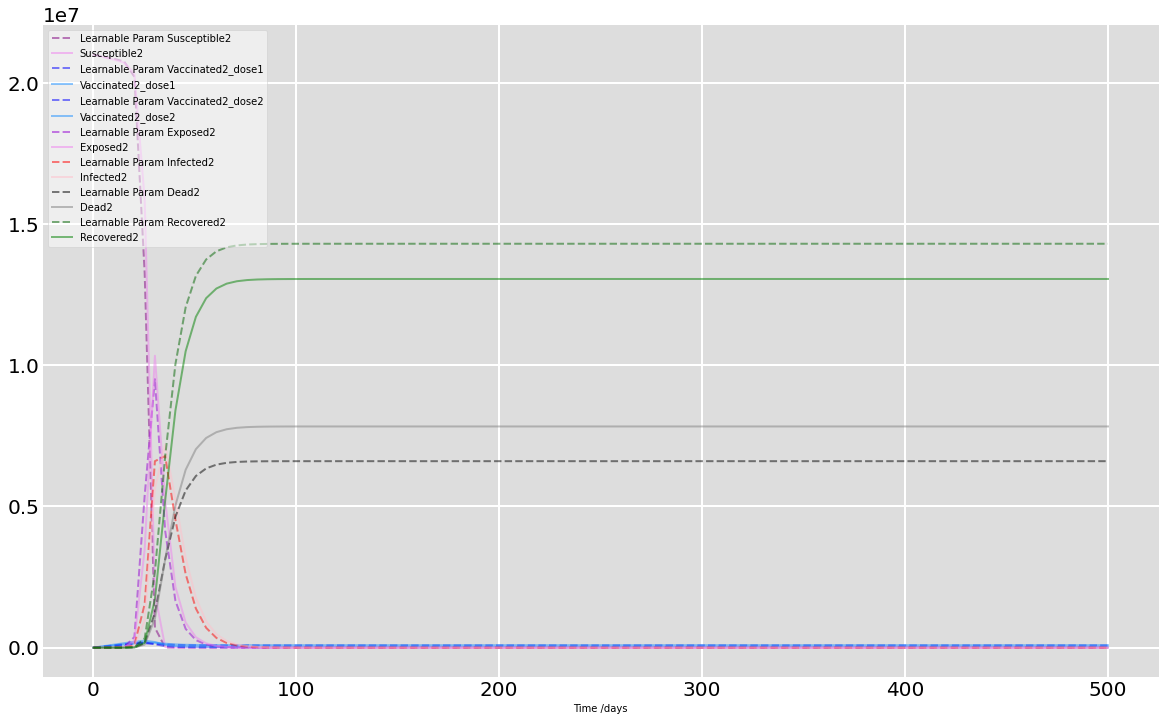

In [8]:
# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(20,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(t, S2, 'purple', alpha=0.5, lw=2, label='Learnable Param Susceptible2', linestyle='dashed')
ax.plot(t, sidr_data[8], 'violet', alpha=0.5, lw=2, label='Susceptible2')

ax.plot(t, V21, 'blue', alpha=0.5, lw=2, label='Learnable Param Vaccinated2_dose1', linestyle='dashed')
ax.plot(t, sidr_data[9], 'dodgerblue', alpha=0.5, lw=2, label='Vaccinated2_dose1')

ax.plot(t, V22, 'blue', alpha=0.5, lw=2, label='Learnable Param Vaccinated2_dose2', linestyle='dashed')
ax.plot(t, sidr_data[10], 'dodgerblue', alpha=0.5, lw=2, label='Vaccinated2_dose2')

ax.plot(t, E2, 'darkviolet', alpha=0.5, lw=2, label='Learnable Param Exposed2', linestyle='dashed')
ax.plot(t, sidr_data[11], 'violet', alpha=0.5, lw=2, label='Exposed2')

ax.plot(t, I2, 'red', alpha=0.5, lw=2, label='Learnable Param Infected2', linestyle='dashed')
ax.plot(t, sidr_data[12], 'pink', alpha=0.5, lw=2, label='Infected2')

ax.plot(t, D2, 'black', alpha=0.5, lw=2, label='Learnable Param Dead2', linestyle='dashed')
ax.plot(t, sidr_data[13], 'grey', alpha=0.5, lw=2, label='Dead2')

ax.plot(t, R2, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Recovered2', linestyle='dashed')
ax.plot(t, sidr_data[14], 'green', alpha=0.5, lw=2, label='Recovered2')

ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.savefig('vacc_output4_3.png')
plt.show()

In [9]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
V_1_total_loss = 0
V_1_den = 0
V_2_total_loss = 0
V_2_den = 0
E_total_loss = 0
E_den = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = sidr_data[1][timestep] - S1[timestep]
  S_total_loss += S_value**2
  S_den += (sidr_data[1][timestep])**2

  V_1_value = sidr_data[2][timestep] - V11[timestep]
  V_1_total_loss += V_1_value**2
  V_1_den += (sidr_data[2][timestep])**2

  V_2_value = sidr_data[3][timestep] - V12[timestep]
  V_2_total_loss += V_2_value**2
  V_2_den += (sidr_data[3][timestep])**2

  E_value = sidr_data[4][timestep] - E1[timestep]
  E_total_loss += E_value**2
  E_den += (sidr_data[4][timestep])**2

  I_value = sidr_data[5][timestep] - I1[timestep]
  I_total_loss += I_value**2
  I_den += (sidr_data[5][timestep])**2

  D_value = sidr_data[6][timestep] - D1[timestep]
  D_total_loss += D_value**2
  D_den += (sidr_data[6][timestep])**2

  R_value = sidr_data[7][timestep] - R1[timestep]
  R_total_loss += R_value**2
  R_den += (sidr_data[7][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
V_1_total_loss = math.sqrt(V_1_total_loss/V_1_den)
V_2_total_loss = math.sqrt(V_2_total_loss/V_2_den)
E_total_loss = math.sqrt(E_total_loss/E_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
D_total_loss = math.sqrt(D_total_loss/D_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S1_total_loss: ', S_total_loss)
print('V11_total_loss: ', V_1_total_loss)
print('V12_total_loss: ', V_2_total_loss)
print('E1_total_loss: ', E_total_loss)
print('I1_total_loss: ', I_total_loss)
print('D1_total_loss: ', D_total_loss)
print('R1_total_loss: ', R_total_loss)

S1_total_loss:  0.06959216355038975
V11_total_loss:  0.0831754348576169
V12_total_loss:  0.3018823763485382
E1_total_loss:  0.2374126420387476
I1_total_loss:  0.13082552304350467
D1_total_loss:  0.15638704097039227
R1_total_loss:  0.09761991979032476


In [10]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
V_1_total_loss = 0
V_1_den = 0
V_2_total_loss = 0
V_2_den = 0
E_total_loss = 0
E_den = 0
I_total_loss = 0
I_den = 0
D_total_loss = 0
D_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = sidr_data[8][timestep] - S2[timestep]
  S_total_loss += S_value**2
  S_den += (sidr_data[8][timestep])**2

  V_1_value = sidr_data[9][timestep] - V21[timestep]
  V_1_total_loss += V_1_value**2
  V_1_den += (sidr_data[9][timestep])**2

  V_2_value = sidr_data[10][timestep] - V22[timestep]
  V_2_total_loss += V_2_value**2
  V_2_den += (sidr_data[10][timestep])**2

  E_value = sidr_data[11][timestep] - E2[timestep]
  E_total_loss += E_value**2
  E_den += (sidr_data[11][timestep])**2

  I_value = sidr_data[12][timestep] - I2[timestep]
  I_total_loss += I_value**2
  I_den += (sidr_data[12][timestep])**2

  D_value = sidr_data[13][timestep] - D2[timestep]
  D_total_loss += D_value**2
  D_den += (sidr_data[13][timestep])**2

  R_value = sidr_data[14][timestep] - R2[timestep]
  R_total_loss += R_value**2
  R_den += (sidr_data[14][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)
V_1_total_loss = math.sqrt(V_1_total_loss/V_1_den)
V_2_total_loss = math.sqrt(V_2_total_loss/V_2_den)
E_total_loss = math.sqrt(E_total_loss/E_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
D_total_loss = math.sqrt(D_total_loss/D_den)
R_total_loss = math.sqrt(R_total_loss/R_den)

print('S2_total_loss: ', S_total_loss)
print('V21_total_loss: ', V_1_total_loss)
print('V22_total_loss: ', V_2_total_loss)
print('E2_total_loss: ', E_total_loss)
print('I2_total_loss: ', I_total_loss)
print('D2_total_loss: ', D_total_loss)
print('R2_total_loss: ', R_total_loss)

S2_total_loss:  0.05858417252203346
V21_total_loss:  0.09393328728180272
V22_total_loss:  0.3362167138464722
E2_total_loss:  0.19462344802923545
I2_total_loss:  0.1406438227282921
D2_total_loss:  0.1558993916866454
R2_total_loss:  0.09838180497335765
